In [1]:
NAME = "Somanich Bunlee"
COLLABORATORS = ""

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import ast  # For parsing JSON-like strings

In [3]:
# Load the dataset
movies_df = pd.read_csv(r'../data/tmdb_5000_movies.csv')

# Quick Overview
print(movies_df.info())
print(movies_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                4803 non-null   int64  
 1   genres                4803 non-null   object 
 2   homepage              1712 non-null   object 
 3   id                    4803 non-null   int64  
 4   keywords              4803 non-null   object 
 5   original_language     4803 non-null   object 
 6   original_title        4803 non-null   object 
 7   overview              4800 non-null   object 
 8   popularity            4803 non-null   float64
 9   production_companies  4803 non-null   object 
 10  production_countries  4803 non-null   object 
 11  release_date          4802 non-null   object 
 12  revenue               4803 non-null   int64  
 13  runtime               4801 non-null   float64
 14  spoken_languages      4803 non-null   object 
 15  status               

### Data Cleaning and Preprocessing

In [4]:
# Drop duplicate rows if any
movies_df = movies_df.drop_duplicates()

# Handle missing values
movies_df = movies_df.dropna(subset=['budget', 'revenue', 'genres', 'popularity'])

# Convert budget and revenue to numeric (ensure they're in numeric format)
movies_df['budget'] = pd.to_numeric(movies_df['budget'], errors='coerce')
movies_df['revenue'] = pd.to_numeric(movies_df['revenue'], errors='coerce')

# Fill or drop missing data in critical columns (e.g., runtime)
movies_df['runtime'] = movies_df['runtime'].fillna(movies_df['runtime'].median())

### Feature Engineering


In [5]:
# Create profit_margin
movies_df['profit_margin'] = (movies_df['revenue'] - movies_df['budget']) / movies_df['budget']

# Extract genres into a list
import ast
movies_df['genres_list'] = movies_df['genres'].apply(lambda x: [genre['name'] for genre in ast.literal_eval(x)] if pd.notnull(x) else [])

### Exploratory Data Analysis (EDA)
Relationship Between Genres, Popularity, and Revenue

                 popularity       revenue  vote_average
genres_list                                            
Adventure         39.268042  2.086602e+08      6.156962
Animation         38.813439  2.256930e+08      6.341453
Science Fiction   36.451806  1.524565e+08      6.005607
Fantasy           36.387043  1.933542e+08      6.096698
Action            30.940382  1.412131e+08      5.989515
Family            27.832849  1.623455e+08      6.029630
Mystery           24.586827  7.830093e+07      6.183908
Thriller          24.460077  8.104429e+07      6.010989
War               23.777289  8.415587e+07      6.713889
Crime             22.853274  6.615066e+07      6.274138
Horror            18.295915  4.354508e+07      5.626590
Western           18.236279  4.624596e+07      6.178049
Comedy            18.221001  7.128950e+07      5.945587
Drama             17.764853  5.211623e+07      6.388594
History           17.444839  5.752356e+07      6.719797
Romance           15.962426  6.000239e+07      6

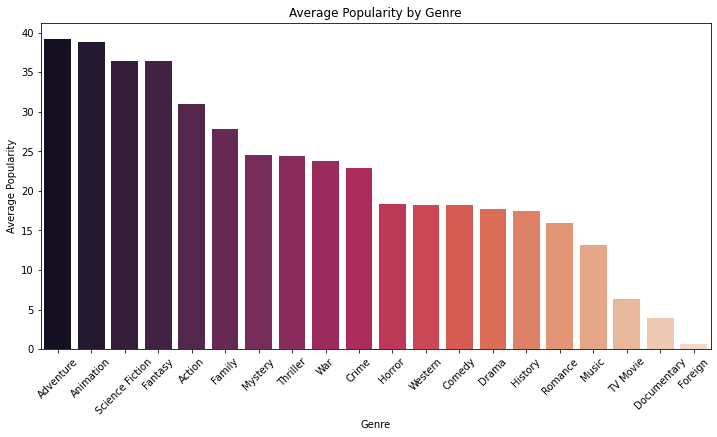

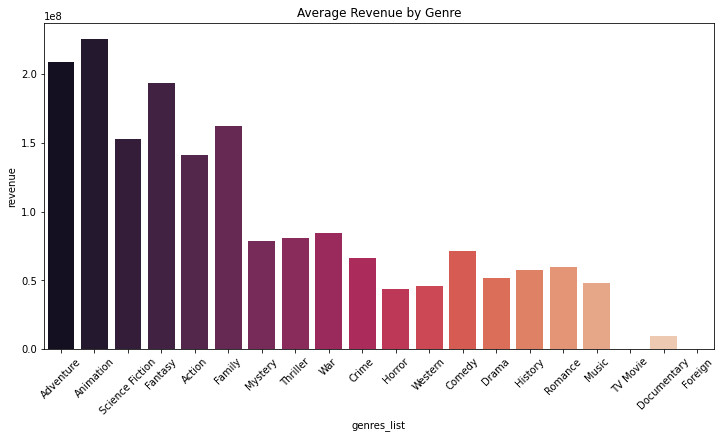

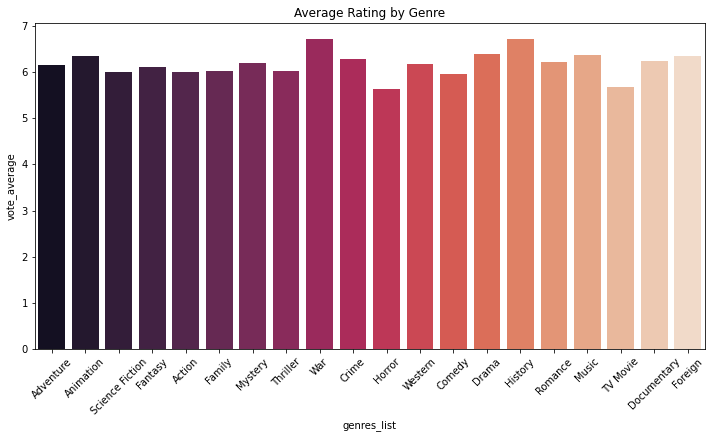

In [6]:
# Relationship Between Genres, Popularity, and Revenue

# Exploding genres for analysis
movies_exploded = movies_df.explode('genres_list')

# Average popularity and revenue by genre
genre_analysis = movies_exploded.groupby('genres_list')[['popularity', 'revenue', 'vote_average']].mean().sort_values(by='popularity', ascending=False)
print(genre_analysis)

# Visualizing Average Popularity, Revenue, and Rating by Genre 
plt.figure(figsize=(12, 6))
sns.barplot(data=genre_analysis.reset_index(), x='genres_list', y='popularity', palette='rocket')
plt.title('Average Popularity by Genre')
plt.xlabel('Genre')
plt.ylabel('Average Popularity')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(data=genre_analysis.reset_index(), x='genres_list', y='revenue', palette='rocket')
plt.title('Average Revenue by Genre')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(data=genre_analysis.reset_index(), x='genres_list', y='vote_average', palette='rocket')
plt.title('Average Rating by Genre')
plt.xticks(rotation=45)
plt.show()


Release Year and Runtime Analysis

              popularity       revenue
release_year                          
1916.0          3.232447  8.394751e+06
1925.0          0.785744  2.200000e+07
1927.0         32.351527  6.504220e+05
1929.0          1.396524  2.179000e+06
1930.0          8.484123  8.000000e+06
...                  ...           ...
2013.0         28.135912  1.013485e+08
2014.0         37.480126  1.013466e+08
2015.0         37.256857  1.054399e+08
2016.0         37.128692  1.390496e+08
2017.0          0.710870  0.000000e+00

[90 rows x 2 columns]


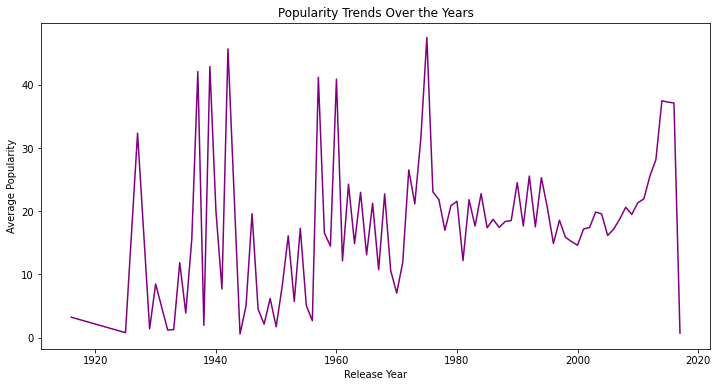

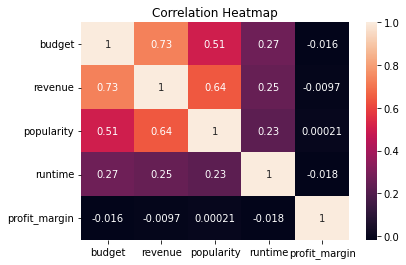

In [7]:
# Converting release_date to datetime and extracting year
movies_df['release_year'] = pd.to_datetime(movies_df['release_date'], errors='coerce').dt.year

# Average popularity and revenue by release year
year_analysis = movies_df.groupby('release_year')[['popularity', 'revenue']].mean()
print(year_analysis)

# Visualizing Popularity and Revenue trends over the years 
plt.figure(figsize=(12, 6))
sns.lineplot(data=year_analysis, x=year_analysis.index, y='popularity', color='purple')
plt.title('Popularity Trends Over the Years')
plt.xlabel('Release Year')
plt.ylabel('Average Popularity')
plt.show()

# Correlation heatmap including profit_margin
movies_df['profit_margin'] = (movies_df['revenue'] - movies_df['budget']) / movies_df['budget']
correlation_matrix = movies_df[['budget', 'revenue', 'popularity', 'runtime', 'profit_margin']].corr()

sns.heatmap(correlation_matrix, annot=True, cmap='rocket')
plt.title('Correlation Heatmap')
plt.show()

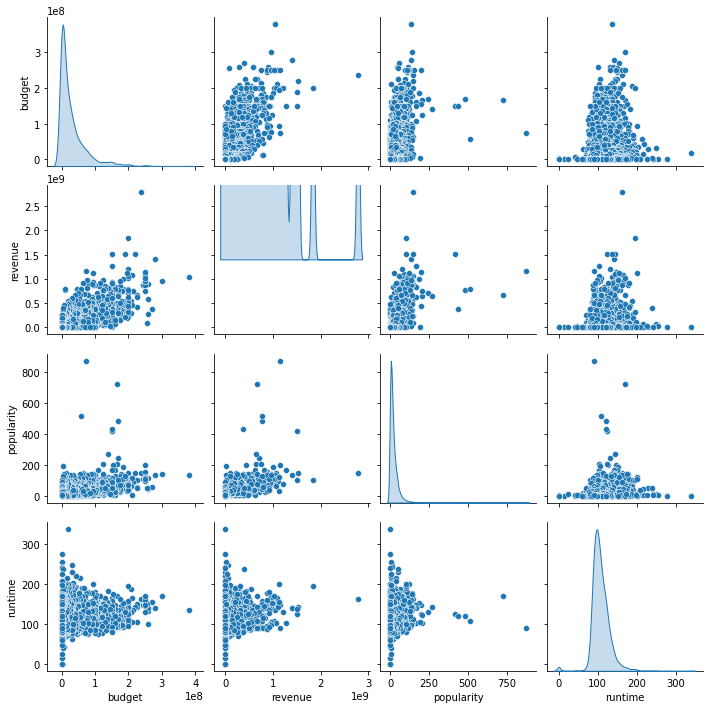

In [8]:
# Pair plots of essential columns (Not included in the paper)
sns.pairplot(movies_df[['budget', 'revenue', 'popularity', 'runtime']], diag_kind='kde')
plt.show()

### Clustering for Recommendations

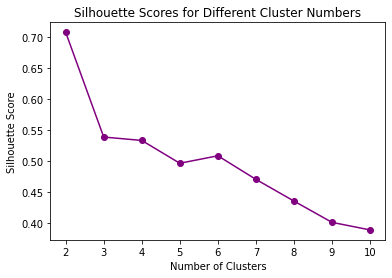

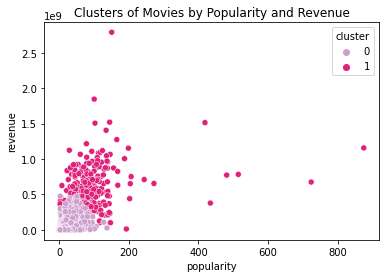

In [9]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score


# Select Relevant Features for clustering
clustering_features = movies_df[['popularity', 'revenue', 'budget']].fillna(0)

# Scale standardize features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(clustering_features)

# Determine the optimal number of clusters (Elbow Method or Silhouette Score)
range_n_clusters = list(range(2, 11))
silhouette_scores = []

for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(scaled_features)
    silhouette_scores.append(silhouette_score(scaled_features, kmeans.labels_))

# Plot silhouette scores
plt.plot(range_n_clusters, silhouette_scores, marker='o', color='purple')
plt.title("Silhouette Scores for Different Cluster Numbers")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.show()

# Apply K-Means Clustering
kmeans = KMeans(n_clusters=2, random_state=42)
movies_df['cluster'] = kmeans.fit_predict(scaled_features)

# Visualize clusters
sns.scatterplot(data=movies_df, x='popularity', y='revenue', hue='cluster', palette='PuRd')
plt.title('Clusters of Movies by Popularity and Revenue')
plt.show()


In [10]:
# View Cluster Insights with K = 2
cluster_insights = movies_df.groupby('cluster')[['budget', 'runtime', 'popularity', 'vote_average']].mean()
print(cluster_insights)

               budget     runtime  popularity  vote_average
cluster                                                    
0        1.939843e+07  105.464886   15.809951      6.041538
1        1.201216e+08  120.180435   75.141096      6.570217


### Content-Based Recommendation System

In [11]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Assuming `movies_df` contains columns: 'title', 'genres_list', 'overview', etc.

# Function to recommend movies based on genre
def recommend_movies_by_genre(input_genre, top_n=5):
    # Filter movies by the genre
    filtered_movies = movies_df[movies_df['genres_list'].apply(lambda x: input_genre in x)]
    # Sort by popularity and return the top_n movies
    recommended = filtered_movies.sort_values('popularity', ascending=False).head(top_n)
    return recommended[['title', 'vote_average', 'genres_list', 'overview']]

# Function to recommend movies based on the movie title (content-based filtering)
def recommend_movies_by_title(input_title, top_n=5):
    # Ensure the movie exists in the dataset
    if input_title not in movies_df['title'].values:
        return "Movie not found in the dataset!"
    
    # Create a TF-IDF vectorizer to convert the 'overview' or other text-based features into vectors
    tfidf_vectorizer = TfidfVectorizer(stop_words='english')
    
    # Fit the vectorizer on the 'overview' column or other features
    tfidf_matrix = tfidf_vectorizer.fit_transform(movies_df['overview'].fillna(''))
    
    # Compute the cosine similarity between the input movie and all other movies
    input_movie_index = movies_df[movies_df['title'] == input_title].index[0]
    cosine_similarities = cosine_similarity(tfidf_matrix[input_movie_index], tfidf_matrix).flatten()
    
    # Get the indices of the most similar movies (excluding the input movie itself)
    similar_indices = cosine_similarities.argsort()[-top_n-1:-1][::-1]
    
    # Return the top_n similar movies
    similar_movies = movies_df.iloc[similar_indices]
    return similar_movies[['title', 'vote_average', 'genres_list', 'overview']]

# Main function to take input from the user
def recommend_movies(input_value, top_n=5):
    # Check if the input is a movie title or a genre
    if input_value in movies_df['title'].values:
        # Call the title-based recommendation function
        print(f"\nRecommendations based on movie title: '{input_value}'")
        recommendations = recommend_movies_by_title(input_value, top_n)
    else:
        # Call the genre-based recommendation function
        print(f"\nRecommendations based on genre: '{input_value}'")
        recommendations = recommend_movies_by_genre(input_value, top_n)
    
    print(recommendations)

# Continuous loop for getting user input
def interactive_recommendation_system():
    while True:
        # Get input from the user
        user_input = input("\nEnter a movie title or genre to get recommendations (or type 'exit' to quit): ").strip()
        
        if user_input.lower() == 'exit':
            print("Exiting the recommendation system. Goodbye!")
            break  # Exit the loop if user types 'exit'
        
        # Get top 5 recommendations
        recommend_movies(user_input, top_n=5)

# Run the interactive recommendation system
interactive_recommendation_system()


Enter a movie title or genre to get recommendations (or type 'exit' to quit): Action

Recommendations based on genre: 'Action'
                                                 title  vote_average  \
788                                           Deadpool           7.4   
94                             Guardians of the Galaxy           7.9   
127                                 Mad Max: Fury Road           7.2   
28                                      Jurassic World           6.5   
199  Pirates of the Caribbean: The Curse of the Bla...           7.5   

                                        genres_list  \
788                     [Action, Adventure, Comedy]   
94             [Action, Science Fiction, Adventure]   
127  [Action, Adventure, Science Fiction, Thriller]   
28   [Action, Adventure, Science Fiction, Thriller]   
199                    [Adventure, Fantasy, Action]   

                                              overview  
788  Deadpool tells the origin story of former Spec

### Regression Analysis
Predict popularity or revenue using features like budget, genres, and runtime.

In [12]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Prepare features and target for regression model
features = ['budget', 'revenue', 'runtime']
target = 'popularity'

# Drop rows with missing values in features
movies_df = movies_df.dropna(subset=features)

# Split data into training and testing sets
X = movies_df[features]
y = movies_df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit a linear regression model
reg_model = LinearRegression()
reg_model.fit(X_train, y_train)

# Make predictions
y_pred = reg_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = reg_model.predict(X_test)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print('RMSE:', mean_squared_error(y_test, y_pred, squared=False))
print(f"R^2 Score: {r2:.2f}")

Mean Squared Error: 749.66
RMSE: 27.37997069789022
R^2 Score: 0.39
